# Day 5: Regularization Techniques

**Topics:**
- Overfitting in trading models
- L1/L2 regularization
- Dropout
- Batch normalization
- Early stopping

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 5: Regularization Techniques")

✅ Libraries loaded!
📚 Day 5: Regularization Techniques


---

## Part 1: The Overfitting Problem

Overfitting occurs when a model learns noise in the training data instead of the underlying pattern.

OVERFITTING DEMONSTRATION


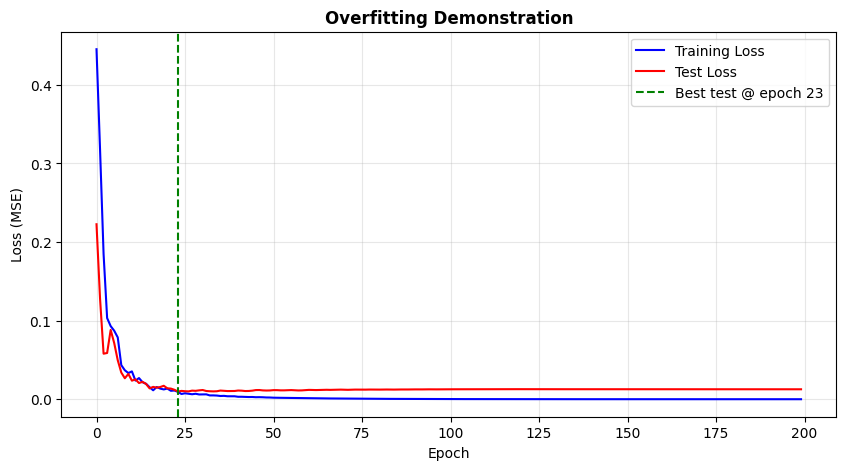


📊 OVERFITTING ANALYSIS:
• Final train loss: 0.000002
• Final test loss:  0.012650
• Test loss ratio:  7265.4x (higher = worse)

⚠️  Gap between train/test loss = OVERFITTING!


In [2]:
# Demonstrate overfitting with synthetic stock data
print("OVERFITTING DEMONSTRATION")
print("="*60)

# Generate synthetic data with noise
np.random.seed(42)
n_samples = 200

# Features: technical indicators
X = np.random.randn(n_samples, 10)
# True relationship: simple linear with some features
true_weights = np.array([0.5, -0.3, 0.2, 0, 0, 0, 0, 0, 0, 0])
y = X @ true_weights + 0.1 * np.random.randn(n_samples)  # Add noise

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert to tensors
X_train_t = torch.FloatTensor(X_train)
X_test_t = torch.FloatTensor(X_test)
y_train_t = torch.FloatTensor(y_train).unsqueeze(1)
y_test_t = torch.FloatTensor(y_test).unsqueeze(1)

# Overly complex model (will overfit)
class OverfitModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

# Train without regularization
model = OverfitModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

train_losses, test_losses = [], []
epochs = 200

for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train_t)
    train_loss = criterion(train_pred, y_train_t)
    train_loss.backward()
    optimizer.step()
    
    # Evaluation
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = criterion(test_pred, y_test_t)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.axvline(x=np.argmin(test_losses), color='green', linestyle='--', 
            label=f'Best test @ epoch {np.argmin(test_losses)}')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Overfitting Demonstration', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 OVERFITTING ANALYSIS:")
print(f"• Final train loss: {train_losses[-1]:.6f}")
print(f"• Final test loss:  {test_losses[-1]:.6f}")
print(f"• Test loss ratio:  {test_losses[-1]/train_losses[-1]:.1f}x (higher = worse)")
print(f"\n⚠️  Gap between train/test loss = OVERFITTING!")

---

## Part 2: L1 and L2 Regularization (Weight Decay)

**L2 Regularization (Ridge):**
$$L_{total} = L_{data} + \lambda \sum_i w_i^2$$

**L1 Regularization (Lasso):**
$$L_{total} = L_{data} + \lambda \sum_i |w_i|$$

L2 REGULARIZATION (WEIGHT DECAY)


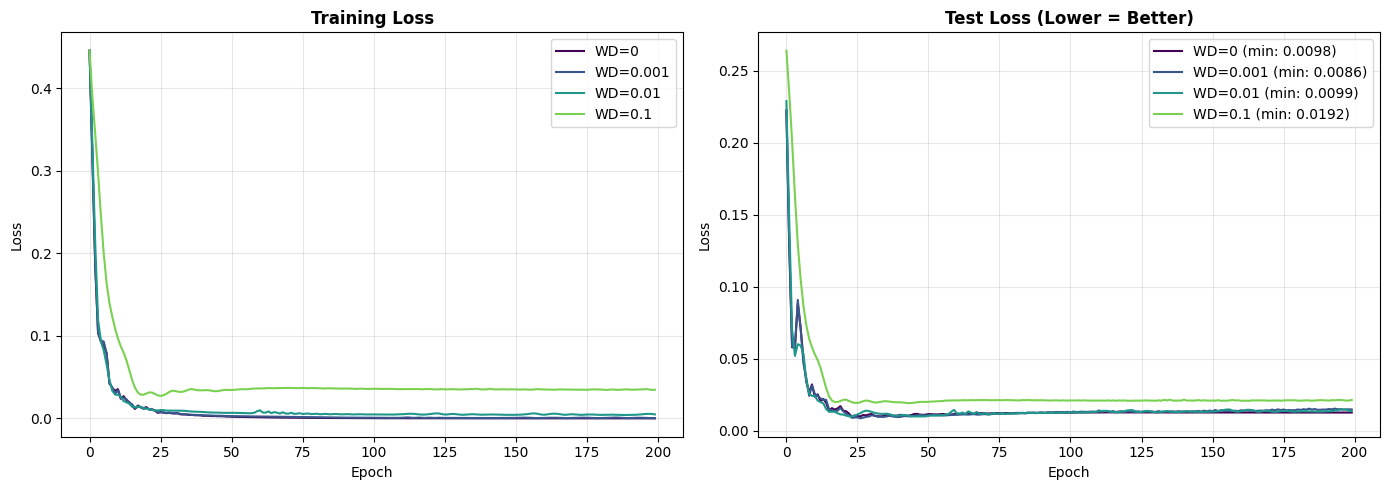


📊 WEIGHT DECAY COMPARISON:
--------------------------------------------------
WD=    0 | Final Test: 0.0126 | Best Test: 0.0098
WD=0.001 | Final Test: 0.0148 | Best Test: 0.0086
WD= 0.01 | Final Test: 0.0137 | Best Test: 0.0099
WD=  0.1 | Final Test: 0.0214 | Best Test: 0.0192


In [3]:
# Compare no regularization vs L2
print("L2 REGULARIZATION (WEIGHT DECAY)")
print("="*60)

def train_model(weight_decay=0, epochs=200):
    torch.manual_seed(42)
    model = OverfitModel()
    optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train_t)
        train_loss = criterion(train_pred, y_train_t)
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Compare different weight decay values
weight_decays = [0, 0.001, 0.01, 0.1]
results = {wd: train_model(wd) for wd in weight_decays}

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = plt.cm.viridis(np.linspace(0, 0.8, len(weight_decays)))

for (wd, (train_losses, test_losses)), color in zip(results.items(), colors):
    axes[0].plot(train_losses, color=color, label=f'WD={wd}')
    axes[1].plot(test_losses, color=color, label=f'WD={wd} (min: {min(test_losses):.4f})')

axes[0].set_title('Training Loss', fontweight='bold')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].set_title('Test Loss (Lower = Better)', fontweight='bold')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 WEIGHT DECAY COMPARISON:")
print("-"*50)
for wd, (train, test) in results.items():
    print(f"WD={wd:5} | Final Test: {test[-1]:.4f} | Best Test: {min(test):.4f}")

---

## Part 3: Dropout

Randomly sets a fraction of inputs to zero during training, preventing co-adaptation of neurons.

In [4]:
# Dropout visualization
print("DROPOUT MECHANISM")
print("="*60)

# Visualize dropout effect
dropout = nn.Dropout(p=0.3)
x = torch.ones(5, 10)

print("Input (ones):")
print(x[0].numpy())

print("\nAfter Dropout (training mode):")
dropout.train()
for i in range(3):
    out = dropout(x.clone())
    print(f"  Sample {i+1}: {out[0].numpy()} | Zeros: {(out[0]==0).sum().item()}/10")

print("\nAfter Dropout (eval mode):")
dropout.eval()
out = dropout(x)
print(f"  Output: {out[0].numpy()}")
print("  (No dropout during evaluation - outputs scaled)")

DROPOUT MECHANISM
Input (ones):
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]

After Dropout (training mode):
  Sample 1: [1.4285715 1.4285715 0.        1.4285715 1.4285715 1.4285715 0.
 1.4285715 1.4285715 1.4285715] | Zeros: 2/10
  Sample 2: [1.4285715 1.4285715 1.4285715 1.4285715 0.        1.4285715 1.4285715
 1.4285715 1.4285715 0.       ] | Zeros: 2/10
  Sample 3: [1.4285715 0.        1.4285715 0.        1.4285715 1.4285715 1.4285715
 1.4285715 0.        1.4285715] | Zeros: 3/10

After Dropout (eval mode):
  Output: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  (No dropout during evaluation - outputs scaled)



MODEL WITH DROPOUT


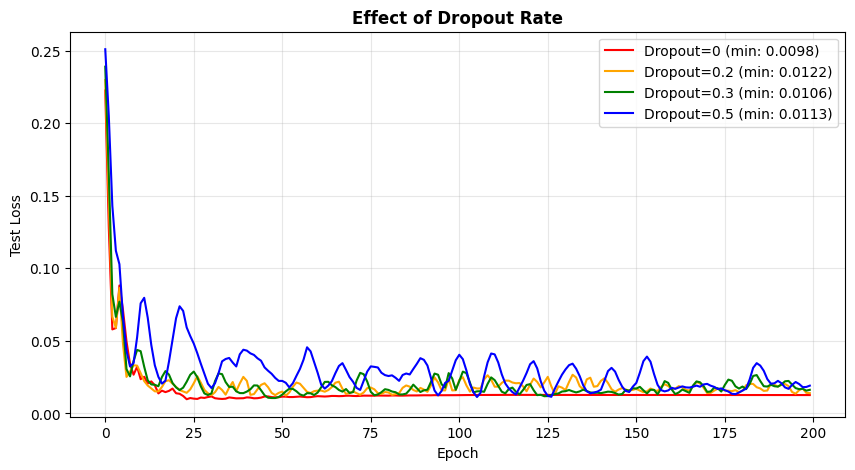


📊 DROPOUT RECOMMENDATIONS:
• Input layers: 0.2-0.3
• Hidden layers: 0.3-0.5
• Too high: Underfitting
• Remember: model.train() / model.eval()!


In [5]:
# Model with Dropout
print("\nMODEL WITH DROPOUT")
print("="*60)

class RegularizedModel(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

def train_with_dropout(dropout_rate=0.3, epochs=200):
    torch.manual_seed(42)
    model = RegularizedModel(dropout_rate)
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()  # Important! Enables dropout
        optimizer.zero_grad()
        train_pred = model(X_train_t)
        train_loss = criterion(train_pred, y_train_t)
        train_loss.backward()
        optimizer.step()
        
        model.eval()  # Important! Disables dropout
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Compare dropout rates
dropout_rates = [0, 0.2, 0.3, 0.5]
dropout_results = {dr: train_with_dropout(dr) for dr in dropout_rates}

# Plot
plt.figure(figsize=(10, 5))
colors = ['red', 'orange', 'green', 'blue']

for (dr, (train, test)), color in zip(dropout_results.items(), colors):
    plt.plot(test, color=color, label=f'Dropout={dr} (min: {min(test):.4f})')

plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Effect of Dropout Rate', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 DROPOUT RECOMMENDATIONS:")
print("• Input layers: 0.2-0.3")
print("• Hidden layers: 0.3-0.5")
print("• Too high: Underfitting")
print("• Remember: model.train() / model.eval()!")

---

## Part 4: Batch Normalization

Normalizes layer inputs to have zero mean and unit variance. Helps with:
- Faster training
- Higher learning rates
- Mild regularization effect

BATCH NORMALIZATION


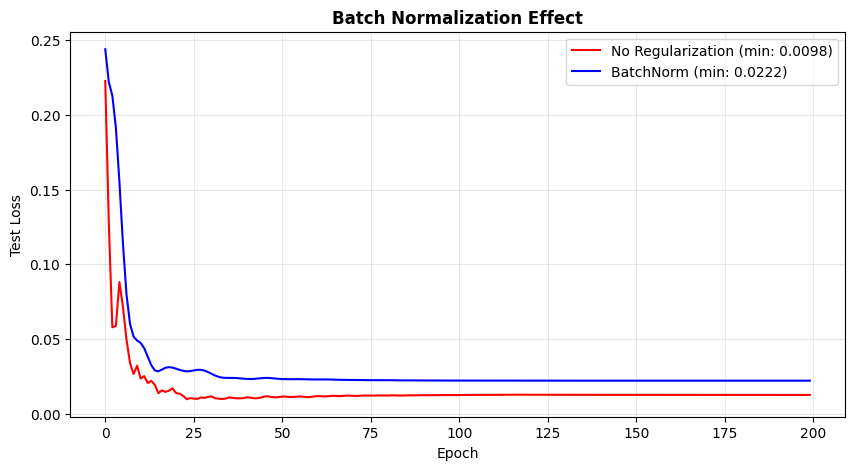


📊 BATCH NORM BENEFITS:
• Normalizes activations (mean=0, std=1)
• Allows higher learning rates
• Acts as mild regularizer
• Place BEFORE activation (debated) or after Linear layer


In [6]:
# Model with Batch Normalization
print("BATCH NORMALIZATION")
print("="*60)

class BatchNormModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(10, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    
    def forward(self, x):
        return self.network(x)

def train_batchnorm(epochs=200):
    torch.manual_seed(42)
    model = BatchNormModel()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.MSELoss()
    
    train_losses, test_losses = [], []
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        train_pred = model(X_train_t)
        train_loss = criterion(train_pred, y_train_t)
        train_loss.backward()
        optimizer.step()
        
        model.eval()
        with torch.no_grad():
            test_pred = model(X_test_t)
            test_loss = criterion(test_pred, y_test_t)
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
    
    return train_losses, test_losses

# Compare
no_reg_train, no_reg_test = train_model(weight_decay=0)
bn_train, bn_test = train_batchnorm()

plt.figure(figsize=(10, 5))
plt.plot(no_reg_test, label=f'No Regularization (min: {min(no_reg_test):.4f})', color='red')
plt.plot(bn_test, label=f'BatchNorm (min: {min(bn_test):.4f})', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Batch Normalization Effect', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 BATCH NORM BENEFITS:")
print("• Normalizes activations (mean=0, std=1)")
print("• Allows higher learning rates")
print("• Acts as mild regularizer")
print("• Place BEFORE activation (debated) or after Linear layer")

---

## Part 5: Early Stopping

EARLY STOPPING

🛑 Early stopping at epoch 43
   Best test loss: 0.009782


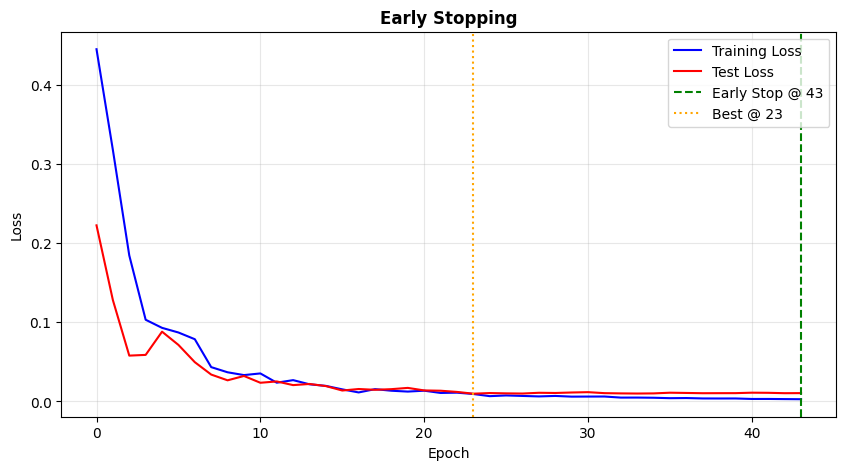


📊 EARLY STOPPING TIPS:
• Patience: 10-20 epochs typically
• Monitor validation loss, not training loss
• Save best model weights!


In [7]:
# Early stopping implementation
print("EARLY STOPPING")
print("="*60)

class EarlyStopping:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
        self.best_model_state = None
        
    def __call__(self, val_loss, model):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.best_model_state = model.state_dict().copy()
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        return self.early_stop

# Train with early stopping
torch.manual_seed(42)
model = OverfitModel()
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=20)

train_losses, test_losses = [], []
stopped_epoch = 0

for epoch in range(500):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train_t)
    train_loss = criterion(train_pred, y_train_t)
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = criterion(test_pred, y_test_t)
    
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    if early_stopping(test_loss.item(), model):
        stopped_epoch = epoch
        print(f"\n🛑 Early stopping at epoch {epoch}")
        print(f"   Best test loss: {early_stopping.best_loss:.6f}")
        break

# Restore best model
model.load_state_dict(early_stopping.best_model_state)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(test_losses, label='Test Loss', color='red')
plt.axvline(x=stopped_epoch, color='green', linestyle='--', label=f'Early Stop @ {stopped_epoch}')
plt.axvline(x=np.argmin(test_losses), color='orange', linestyle=':', label=f'Best @ {np.argmin(test_losses)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Early Stopping', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n📊 EARLY STOPPING TIPS:")
print("• Patience: 10-20 epochs typically")
print("• Monitor validation loss, not training loss")
print("• Save best model weights!")

---

## Part 6: Complete Regularized Trading Model

COMPLETE REGULARIZED TRADING MODEL
Early stopping at epoch 74


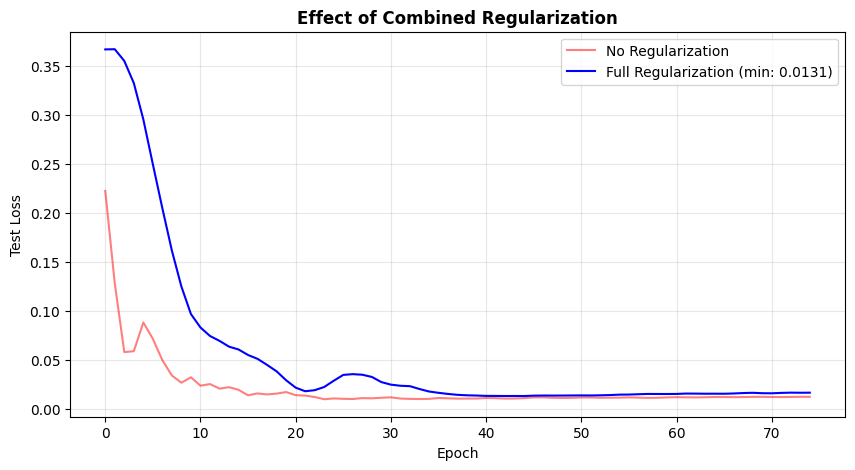


📊 FINAL COMPARISON:
• No regularization best:  0.009782
• Full regularization best: 0.013055
• Improvement: -33.5%


In [8]:
# Full regularized model for trading
print("COMPLETE REGULARIZED TRADING MODEL")
print("="*60)

class TradingModel(nn.Module):
    """Production-ready trading model with all regularization techniques."""
    
    def __init__(self, input_dim, dropout_rate=0.3):
        super().__init__()
        
        self.input_bn = nn.BatchNorm1d(input_dim)
        
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(32, 16)
        self.bn3 = nn.BatchNorm1d(16)
        self.drop3 = nn.Dropout(dropout_rate)
        
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        x = self.input_bn(x)
        
        x = self.fc1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.drop1(x)
        
        x = self.fc2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.drop2(x)
        
        x = self.fc3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.drop3(x)
        
        return self.output(x)

# Train full model
torch.manual_seed(42)
model = TradingModel(input_dim=10, dropout_rate=0.3)
optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=0.01)  # L2 reg
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10)
criterion = nn.MSELoss()
early_stopping = EarlyStopping(patience=30)

train_losses, test_losses = [], []

for epoch in range(300):
    model.train()
    optimizer.zero_grad()
    train_pred = model(X_train_t)
    train_loss = criterion(train_pred, y_train_t)
    train_loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        test_pred = model(X_test_t)
        test_loss = criterion(test_pred, y_test_t)
    
    scheduler.step(test_loss)
    train_losses.append(train_loss.item())
    test_losses.append(test_loss.item())
    
    if early_stopping(test_loss.item(), model):
        print(f"Early stopping at epoch {epoch}")
        break

# Restore best model
model.load_state_dict(early_stopping.best_model_state)

# Compare with unregularized
plt.figure(figsize=(10, 5))
plt.plot(no_reg_test[:len(test_losses)], label=f'No Regularization', color='red', alpha=0.5)
plt.plot(test_losses, label=f'Full Regularization (min: {min(test_losses):.4f})', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Effect of Combined Regularization', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"\n📊 FINAL COMPARISON:")
print(f"• No regularization best:  {min(no_reg_test):.6f}")
print(f"• Full regularization best: {min(test_losses):.6f}")
print(f"• Improvement: {(min(no_reg_test) - min(test_losses))/min(no_reg_test)*100:.1f}%")

---

## 📝 Day 5 Summary

### Regularization Techniques:

| Technique | Purpose | Typical Values |
|-----------|---------|----------------|
| L2 (Weight Decay) | Penalize large weights | 0.001 - 0.01 |
| Dropout | Prevent co-adaptation | 0.2 - 0.5 |
| Batch Norm | Normalize activations | Per layer |
| Early Stopping | Stop before overfitting | patience=10-30 |

### Trading Model Checklist:
- ✅ Dropout after hidden layers
- ✅ BatchNorm for faster/stable training
- ✅ AdamW with weight decay
- ✅ Early stopping with patience
- ✅ Save best model weights

In [11]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║         DAY 5 COMPLETE: REGULARIZATION TECHNIQUES                ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Overfitting diagnosis                                        ║
║  ✓ L1/L2 regularization (weight decay)                          ║
║  ✓ Dropout                                                      ║
║  ✓ Batch normalization                                          ║
║  ✓ Early stopping                                               ║
║  ✓ Complete regularized trading model                           ║
╚══════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════╗
║         DAY 5 COMPLETE: REGULARIZATION TECHNIQUES                ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Overfitting diagnosis                                        ║
║  ✓ L1/L2 regularization (weight decay)                          ║
║  ✓ Dropout                                                      ║
║  ✓ Batch normalization                                          ║
║  ✓ Early stopping                                               ║
║  ✓ Complete regularized trading model                           ║
╚══════════════════════════════════════════════════════════════════╝

